In [44]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
# we need those for the first run and also all colab runs -Beray
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [72]:
df = pd.read_csv("/content/drive/MyDrive/Colab/UWR_DataScienceMaster/Project/spam.csv",encoding = "ISO-8859-1")

In [73]:
df.sample(5)

,v1,v2
2573,spam,Congrats 2 mobile 3G Videophones R yours. call...
4505,ham,When are you guys leaving?
1158,ham,Hey! There's veggie pizza... :/
2408,ham,Dear where you will be when i reach there
3395,spam,URGENT! Your Mobile number has been awarded wi...


In [18]:
df.shape

(5572, 2)

# 1. Data Cleaning
# 2. EDA
# 3. Text preprocessing
# 4. Model Building
# 5. Evaluation
# 6. Improvement

## 1. Data Cleaning

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


## I saw this cell late, I've adjusted the csv data so now we do not need this cell -Beray

In [20]:
# drop last three columns
#df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)
#df.sample(5)

KeyError: ignored

In [21]:
#renaming the cols
df.rename(columns={'v1':'target','v2':'text'},inplace=True)
df.sample(5)

,target,text
2735,ham,I meant middle left or right?
2978,spam,"Xmas Offer! Latest Motorola, SonyEricsson & No..."
3142,ham,Boy; I love u Grl: Hogolo Boy: gold chain kods...
4963,spam,Dear Voucher holder Have your next meal on us....
2842,ham,"Tunji, how's the queen? how are you doing. Thi..."


In [22]:
encoder = LabelEncoder()

In [23]:
df['target'] = encoder.fit_transform(df['target'])
df.sample(5)

,target,text
1398,0,No did you check? I got his detailed message now
2154,0,Oh god i am happy to see your message after 3 ...
2457,0,K.k..how is your sister kids?
550,0,Imagine you finally get to sink into that bath...
2302,0,We can make a baby in yo tho


In [24]:
# missing values
df.isnull().sum()

target    0
text      0
dtype: int64

In [25]:
#check for duplicates
df.duplicated().sum()

403

In [26]:
# remove duplicates
df = df.drop_duplicates(keep='first')
df.shape

(5169, 2)

## 2. EDA

In [27]:
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

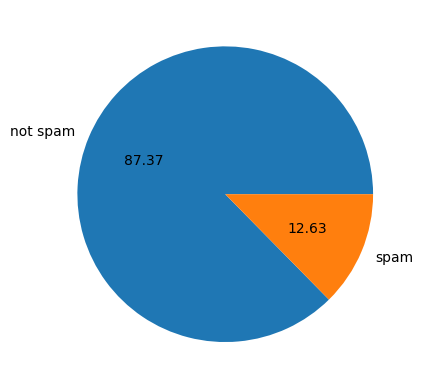

In [28]:
plt.pie(df['target'].value_counts(), labels=['not spam','spam'], autopct="%0.2f")
plt.show()

## Data is imbalanced (Less of spam mails used in dataset)

In [30]:
df['num_characters'] = df['text'].apply(len)
df.sample(5)

<ipython-input-30-74b720b11103>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_characters'] = df['text'].apply(len)


,target,text,num_characters
4687,0,Hmmm.but you should give it on one day..,40
426,0,aathi..where are you dear..,27
3331,0,Ok... The theory test? when are ÃÂ_ going to...,132
4611,0,Sorry da. I gone mad so many pending works wha...,54
5198,0,She.s fine. I have had difficulties with her p...,116


In [33]:
#num of words
df['num_of_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df.sample(5)

,target,text,num_characters,num_of_words
4117,0,Watch lor. I saw a few swatch one i thk quite ...,87,22
1533,0,Horrible bf... I now v hungry...,32,8
2232,0,Nothing just getting msgs by dis name wit diff...,58,12
2572,0,"The house is on the water with a dock, a boat ...",116,25
425,0,Ok. She'll be ok. I guess,25,8


In [34]:
#num of sentences
df['num_of_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.sample(5)

,target,text,num_characters,num_of_words,num_of_sentences
4217,0,Actually i'm waiting for 2 weeks when they sta...,60,13,1
1911,0,Lol grr my mom is taking forever with my presc...,92,20,3
228,0,Life is more strict than teacher... Bcoz Teach...,165,35,4
1968,0,2 laptop... I noe infra but too slow lar... I ...,58,15,3
79,0,Its not the same here. Still looking for a job...,76,20,3


# I added a round beacuse otherwise there were a lot of 0's :D -Beray

In [35]:
round(df[['num_characters','num_of_words','num_of_sentences']].describe(), 2)

,num_characters,num_of_words,num_of_sentences
count,5169.0,5169.00,5169.00
mean,79.6,18.46,1.97
std,58.7,13.33,1.45
min,2.0,1.00,1.00
25%,36.0,9.00,1.00
50%,61.0,15.00,1.00
75%,118.0,26.00,2.00
max,910.0,220.00,38.00


In [36]:
# describing not spam
round(df[df['target'] == 0][['num_characters','num_of_words','num_of_sentences']].describe(), 2)

,num_characters,num_of_words,num_of_sentences
count,4516.00,4516.00,4516.00
mean,70.81,17.12,1.82
std,56.49,13.49,1.38
min,2.00,1.00,1.00
25%,34.00,8.00,1.00
50%,53.00,13.00,1.00
75%,91.00,22.00,2.00
max,910.00,220.00,38.00


In [37]:
# describing spam
round(df[df['target'] == 1][['num_characters','num_of_words','num_of_sentences']].describe(), 2)

,num_characters,num_of_words,num_of_sentences
count,653.00,653.00,653.00
mean,140.43,27.68,2.98
std,31.14,7.01,1.49
min,13.00,2.00,1.00
25%,133.00,25.00,2.00
50%,151.00,29.00,3.00
75%,160.00,32.00,4.00
max,230.00,46.00,9.00


<Axes: xlabel='num_characters', ylabel='Count'>

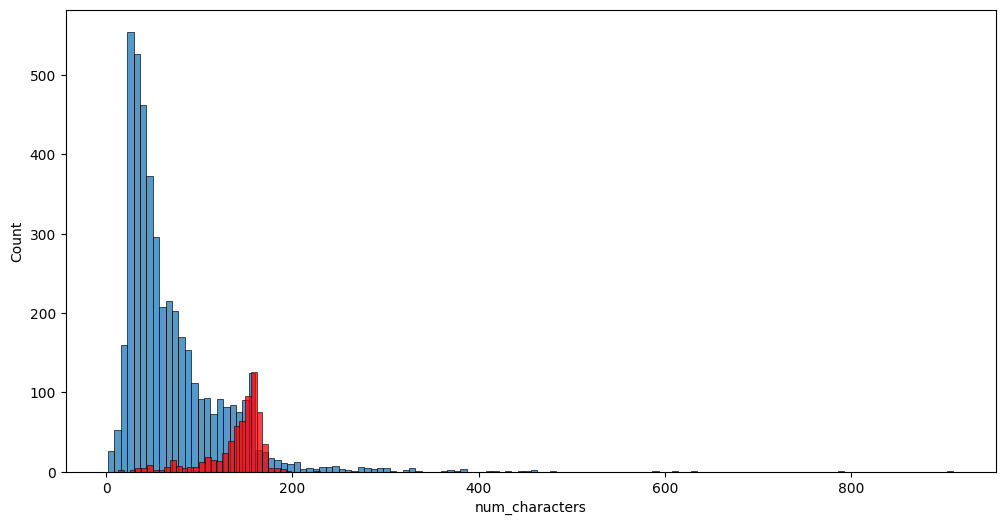

In [38]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'], color='red')

<Axes: xlabel='num_of_words', ylabel='Count'>

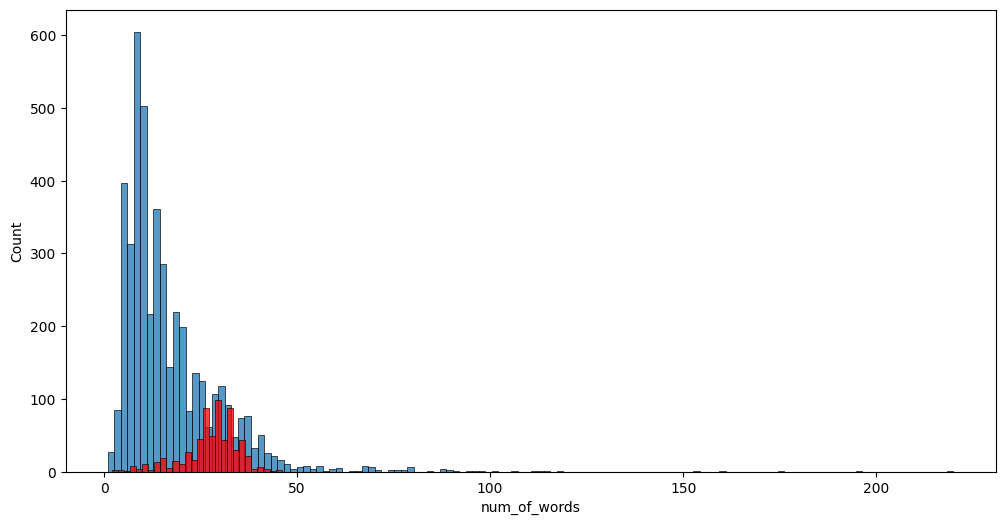

In [39]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_of_words'])
sns.histplot(df[df['target'] == 1]['num_of_words'], color='red')

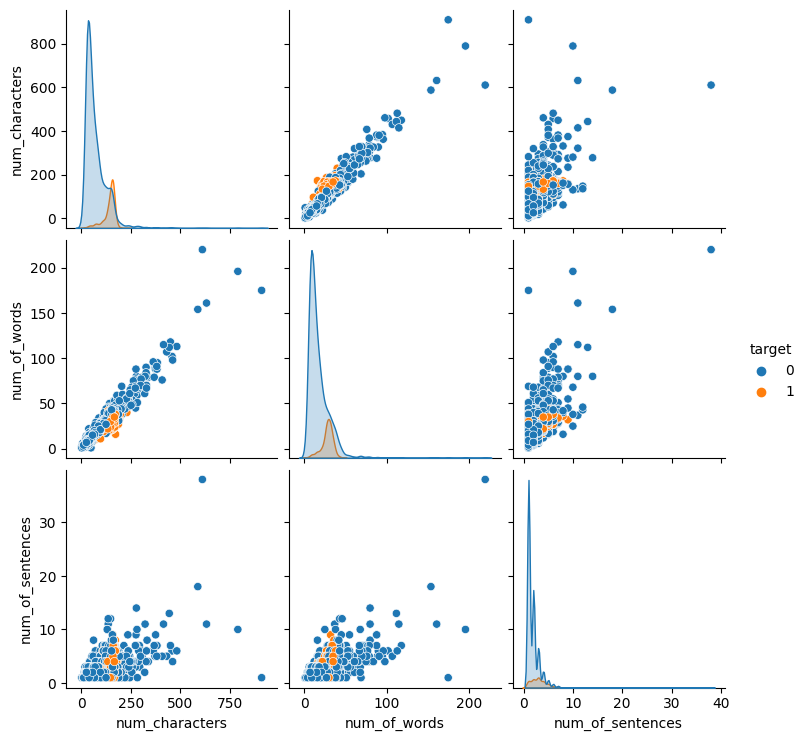

In [40]:
# Check relationship between the columns of dataset
sns.pairplot(df,hue='target')

<ipython-input-41-8df7bcac526d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


<Axes: >

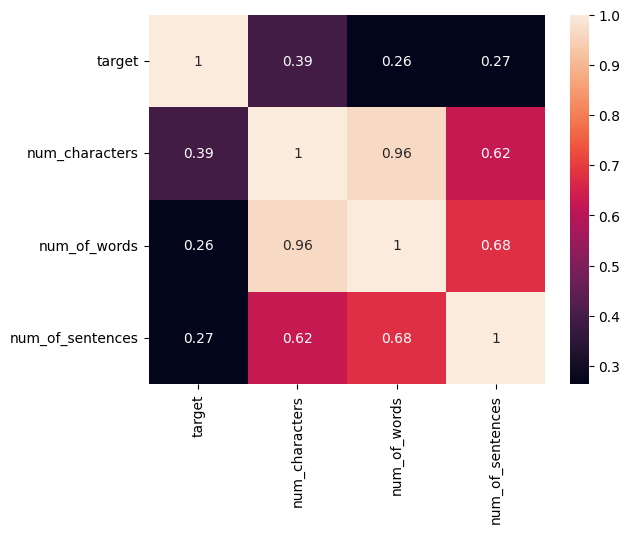

In [41]:
sns.heatmap(df.corr(),annot=True)

## 3. Data preprocessing
- Lower case
- Tokenization
- Removing Special Characters
- Removing Stop words and punctuation
- Stemming

In [42]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()
    ps = PorterStemmer()
    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

In [45]:
df['transformed_text'] = df['text'].apply(transform_text)
df.sample(5)

,target,text,num_characters,num_of_words,num_of_sentences,transformed_text
305,0,Yup... From what i remb... I think should be c...,57,14,2,yup remb think book
2838,0,"Easy mate, * guess the quick drink was bit amb...",53,12,1,easi mate guess quick drink bit ambiti
1725,0,You know there is. I shall speak to you in &l...,67,20,2,know shall speak lt gt minut
1220,1,No. 1 Nokia Tone 4 ur mob every week! Just txt...,143,36,7,1 nokia tone 4 ur mob everi week txt nok 87021...
3156,0,Havent shopping now lor i juz arrive only,41,8,1,havent shop lor juz arriv


## Word Cloud for Spam and Not Spam Emails

In [46]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

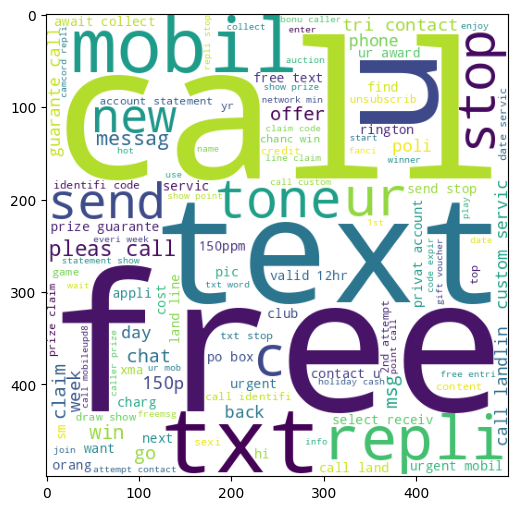

In [47]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

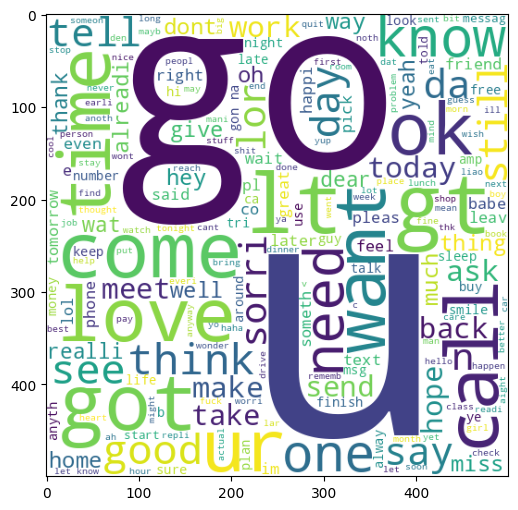

In [48]:
not_spam_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(not_spam_wc)

In [49]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)
len(spam_corpus)

9936

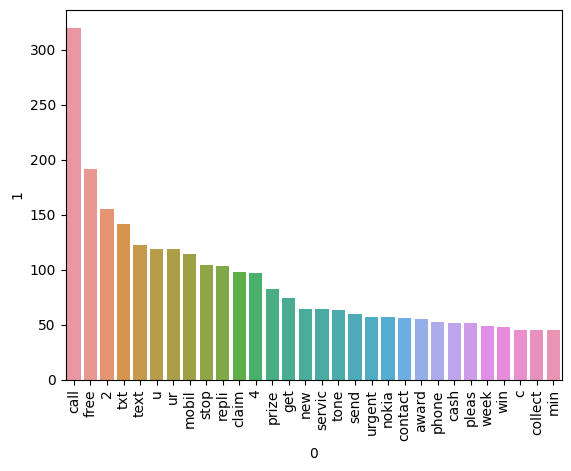

In [51]:
# top 30 words used in the spam emails
sns.barplot(x=pd.DataFrame(Counter(spam_corpus).most_common(30))[0],y=pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [52]:
not_spam_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        not_spam_corpus.append(word)
len(not_spam_corpus)

35305

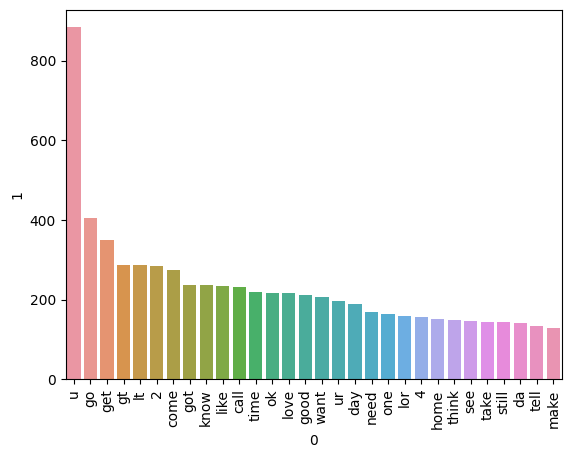

In [53]:
# top 30 words used in the not spam emails
sns.barplot(x=pd.DataFrame(Counter(not_spam_corpus).most_common(30))[0],y=pd.DataFrame(Counter(not_spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

## 4. Model Building

In [55]:
# Using TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values
X.shape

(5169, 6674)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2)

## Bernoulli Naive Bayes performs the best

In [57]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [58]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.874274661508704
[[791 105]
 [ 25 113]]
0.518348623853211


In [59]:
mnb.fit(X_train,y_train)
y_pred2 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.874274661508704
[[791 105]
 [ 25 113]]
0.518348623853211


In [60]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.971953578336557
[[894   2]
 [ 27 111]]
0.9823008849557522


In [61]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
bnb = BernoulliNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear',penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [62]:
clfs = {
    'SVC' : svc,
    'KN' : knc,
    'NB': bnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'ETC': etc,
    'xgb':xgb
}

In [63]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)

    return accuracy,precision

In [64]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance_df

,Algorithm,Accuracy,Precision
1,KN,0.900387,1.000000
5,RF,0.975822,0.991304
2,NB,0.971954,0.982301
6,ETC,0.974855,0.974576
0,SVC,0.972921,0.974138
7,xgb,0.972921,0.958333
4,LR,0.951644,0.940000
3,DT,0.935203,0.838095


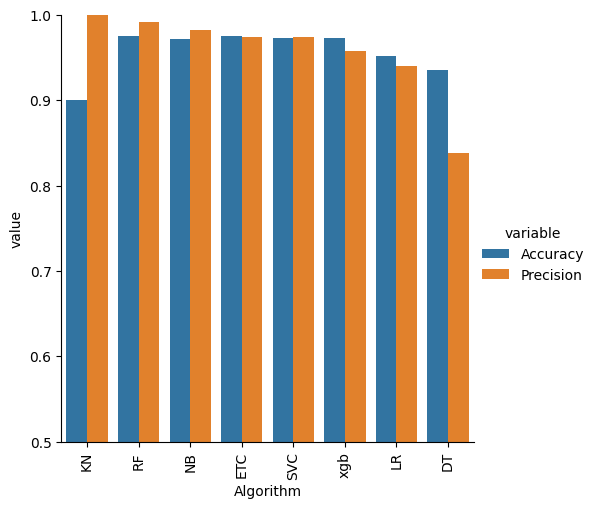

In [65]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")
sns.catplot(x='Algorithm',y='value',hue='variable',data=performance_df1,kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

## Model Improvement
## 1. Change max_features parameter of TfIdf

In [66]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [67]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_max_ft_3000':accuracy_scores,'Precision_ft_3000':precision_scores})
df_max_ft = performance_df.merge(temp_df,on='Algorithm').sort_values('Precision_ft_3000',ascending=False)

## 2. Use scaling

In [68]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [69]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_scaling':accuracy_scores,'Precision_scaling':precision_scores})
df_scaled = df_max_ft.merge(temp_df,on='Algorithm').sort_values('Precision_scaling',ascending=False)
df_scaled['average_score'] = df_scaled[['Accuracy', 'Precision','Accuracy_max_ft_3000','Precision_ft_3000','Accuracy_scaling','Precision_scaling']].mean(axis=1)
df_scaled = df_scaled.sort_values('average_score',ascending=False)
df_scaled

,Algorithm,Accuracy,Precision,Accuracy_max_ft_3000,Precision_ft_3000,Accuracy_scaling,Precision_scaling,average_score
1,NB,0.971954,0.982301,0.983559,0.991870,0.983559,0.991870,0.984185
2,RF,0.975822,0.991304,0.975822,0.991304,0.975822,0.991304,0.983563
3,ETC,0.974855,0.974576,0.978723,0.975410,0.978723,0.975410,0.976283
4,SVC,0.972921,0.974138,0.973888,0.974359,0.969052,0.934426,0.966464
5,LR,0.951644,0.940000,0.956480,0.969697,0.967118,0.964286,0.958204
6,xgb,0.972921,0.958333,0.963250,0.923729,0.963250,0.923729,0.950868
0,KN,0.900387,1.000000,0.905222,1.000000,0.904255,0.975610,0.947579
7,DT,0.935203,0.838095,0.928433,0.826531,0.931335,0.831683,0.881880


In [70]:
# NB RF and ETC are the top 3
# Voting classifier - check if combination of the top 3 models perform better

voting = VotingClassifier(estimators=[('nb',bnb),('rf',rfc),('etc',etc)],voting='soft')
voting.fit(X_train,y_train)
y_pred = voting.predict(X_test)
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Precision: ",precision_score(y_test,y_pred))

Accuracy:  0.9835589941972921
Precision:  1.0


In [71]:
# Apply stacking - gives weightage to the combination of the classifiers according to the final estimator

estimators = [('nb',bnb),('rf',rfc),('etc',etc)]
final_estimator = RandomForestClassifier()
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Precision: ",precision_score(y_test,y_pred))

Accuracy:  0.9835589941972921
Precision:  0.9763779527559056


## We observe that the combination of Naive Bayes, Random Forest and Extra Trees Classifier gave fairly good results.
## The Stacking Classifier did not give good results, so it can be concluded that we can use the combination of these classifiers in equal weightage.